# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

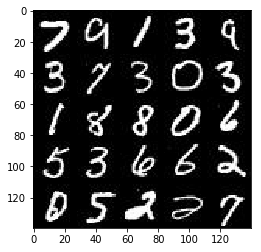

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

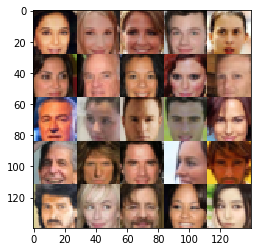

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    global keep_prob
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        relu1 = tf.maximum(alpha * x1, x1)
    
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
       
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
      
        flat = tf.reshape(relu3, (-1, 4*4*512))
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator',reuse = not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
       
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same',
                                            kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        
        
        out = tf.tanh(logits)
    
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every=10
    show_every = 100
    n_images = 50
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr:learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7081... Generator Loss: 0.6541
Epoch 1/2... Discriminator Loss: 1.1579... Generator Loss: 1.1724
Epoch 1/2... Discriminator Loss: 1.5922... Generator Loss: 1.8298
Epoch 1/2... Discriminator Loss: 1.3633... Generator Loss: 0.6789
Epoch 1/2... Discriminator Loss: 1.3806... Generator Loss: 1.1428
Epoch 1/2... Discriminator Loss: 2.0018... Generator Loss: 0.2874
Epoch 1/2... Discriminator Loss: 2.1717... Generator Loss: 0.2335
Epoch 1/2... Discriminator Loss: 1.7564... Generator Loss: 1.2143
Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 2.1205
Epoch 1/2... Discriminator Loss: 1.5006... Generator Loss: 0.9944


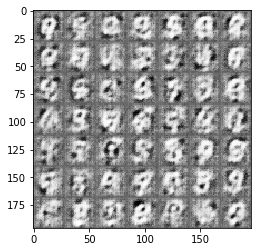

Epoch 1/2... Discriminator Loss: 1.4130... Generator Loss: 0.6464
Epoch 1/2... Discriminator Loss: 1.4488... Generator Loss: 0.5741
Epoch 1/2... Discriminator Loss: 1.6270... Generator Loss: 0.4116
Epoch 1/2... Discriminator Loss: 1.3600... Generator Loss: 2.5751
Epoch 1/2... Discriminator Loss: 1.1865... Generator Loss: 0.9178
Epoch 1/2... Discriminator Loss: 1.2518... Generator Loss: 1.9020
Epoch 1/2... Discriminator Loss: 1.1491... Generator Loss: 1.5181
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 0.6315
Epoch 1/2... Discriminator Loss: 1.5102... Generator Loss: 0.4404
Epoch 1/2... Discriminator Loss: 1.0876... Generator Loss: 0.9494


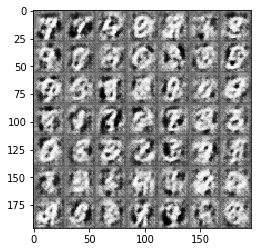

Epoch 1/2... Discriminator Loss: 1.5130... Generator Loss: 0.4380
Epoch 1/2... Discriminator Loss: 1.1281... Generator Loss: 0.7828
Epoch 1/2... Discriminator Loss: 1.1679... Generator Loss: 1.6564
Epoch 1/2... Discriminator Loss: 1.2525... Generator Loss: 2.2404
Epoch 1/2... Discriminator Loss: 1.3682... Generator Loss: 0.5908
Epoch 1/2... Discriminator Loss: 1.1876... Generator Loss: 1.5044
Epoch 1/2... Discriminator Loss: 1.4071... Generator Loss: 2.6520
Epoch 1/2... Discriminator Loss: 1.6821... Generator Loss: 3.0245
Epoch 1/2... Discriminator Loss: 1.4318... Generator Loss: 0.5241
Epoch 1/2... Discriminator Loss: 1.7592... Generator Loss: 2.5367


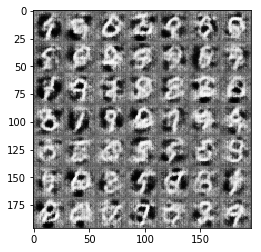

Epoch 1/2... Discriminator Loss: 1.2289... Generator Loss: 0.8169
Epoch 1/2... Discriminator Loss: 1.3049... Generator Loss: 0.7520
Epoch 1/2... Discriminator Loss: 1.4088... Generator Loss: 0.5323
Epoch 1/2... Discriminator Loss: 1.2724... Generator Loss: 0.7744
Epoch 1/2... Discriminator Loss: 1.1868... Generator Loss: 1.1332
Epoch 1/2... Discriminator Loss: 1.4261... Generator Loss: 0.5364
Epoch 1/2... Discriminator Loss: 1.1236... Generator Loss: 0.8382
Epoch 1/2... Discriminator Loss: 1.0667... Generator Loss: 1.4761
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 1.2414
Epoch 1/2... Discriminator Loss: 1.7650... Generator Loss: 0.3988


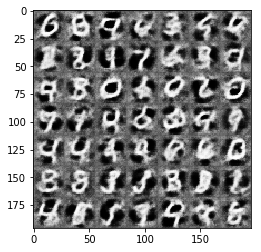

Epoch 1/2... Discriminator Loss: 1.2068... Generator Loss: 1.8562
Epoch 1/2... Discriminator Loss: 1.1149... Generator Loss: 1.0914
Epoch 1/2... Discriminator Loss: 1.3869... Generator Loss: 0.5299
Epoch 1/2... Discriminator Loss: 1.1455... Generator Loss: 1.0831
Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 0.6889
Epoch 1/2... Discriminator Loss: 1.2355... Generator Loss: 0.7385
Epoch 1/2... Discriminator Loss: 1.2613... Generator Loss: 0.6887
Epoch 1/2... Discriminator Loss: 1.1492... Generator Loss: 0.9476
Epoch 1/2... Discriminator Loss: 1.1559... Generator Loss: 1.5571
Epoch 1/2... Discriminator Loss: 1.2201... Generator Loss: 0.7237


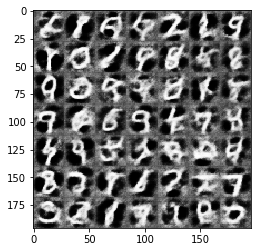

Epoch 1/2... Discriminator Loss: 1.4182... Generator Loss: 0.4903
Epoch 1/2... Discriminator Loss: 1.3995... Generator Loss: 0.5233
Epoch 1/2... Discriminator Loss: 1.1196... Generator Loss: 0.8129
Epoch 1/2... Discriminator Loss: 1.4430... Generator Loss: 0.5189
Epoch 1/2... Discriminator Loss: 1.9877... Generator Loss: 0.2715
Epoch 1/2... Discriminator Loss: 1.4546... Generator Loss: 0.4781
Epoch 1/2... Discriminator Loss: 1.0572... Generator Loss: 1.6143
Epoch 1/2... Discriminator Loss: 1.0559... Generator Loss: 0.9762
Epoch 1/2... Discriminator Loss: 1.1052... Generator Loss: 1.0570
Epoch 1/2... Discriminator Loss: 1.1355... Generator Loss: 0.7471


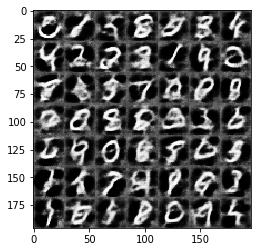

Epoch 1/2... Discriminator Loss: 1.0864... Generator Loss: 0.8992
Epoch 1/2... Discriminator Loss: 1.1701... Generator Loss: 0.8235
Epoch 1/2... Discriminator Loss: 1.0951... Generator Loss: 0.7604
Epoch 1/2... Discriminator Loss: 1.3762... Generator Loss: 0.5557
Epoch 1/2... Discriminator Loss: 1.5928... Generator Loss: 0.4200
Epoch 1/2... Discriminator Loss: 1.1445... Generator Loss: 0.8512
Epoch 1/2... Discriminator Loss: 1.5793... Generator Loss: 2.7098
Epoch 1/2... Discriminator Loss: 1.1357... Generator Loss: 0.8754
Epoch 1/2... Discriminator Loss: 1.0955... Generator Loss: 0.9581
Epoch 1/2... Discriminator Loss: 1.4423... Generator Loss: 0.5001


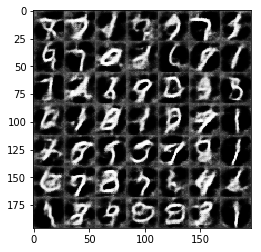

Epoch 1/2... Discriminator Loss: 0.9582... Generator Loss: 1.0655
Epoch 1/2... Discriminator Loss: 1.0739... Generator Loss: 1.4247
Epoch 1/2... Discriminator Loss: 1.4064... Generator Loss: 0.5271
Epoch 1/2... Discriminator Loss: 1.1539... Generator Loss: 1.5355
Epoch 1/2... Discriminator Loss: 1.0268... Generator Loss: 1.7024
Epoch 1/2... Discriminator Loss: 1.0546... Generator Loss: 1.2945
Epoch 1/2... Discriminator Loss: 1.2823... Generator Loss: 0.6197
Epoch 1/2... Discriminator Loss: 0.9018... Generator Loss: 1.7787
Epoch 1/2... Discriminator Loss: 1.2466... Generator Loss: 0.7163
Epoch 1/2... Discriminator Loss: 0.9178... Generator Loss: 1.1803


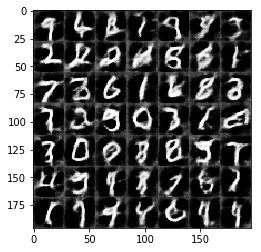

Epoch 1/2... Discriminator Loss: 1.7882... Generator Loss: 2.9094
Epoch 1/2... Discriminator Loss: 1.0545... Generator Loss: 1.3538
Epoch 1/2... Discriminator Loss: 1.0331... Generator Loss: 1.3521
Epoch 1/2... Discriminator Loss: 1.1494... Generator Loss: 1.5737
Epoch 1/2... Discriminator Loss: 1.2436... Generator Loss: 0.6556
Epoch 1/2... Discriminator Loss: 1.0810... Generator Loss: 0.7982
Epoch 1/2... Discriminator Loss: 1.2488... Generator Loss: 0.6509
Epoch 1/2... Discriminator Loss: 1.0037... Generator Loss: 1.1546
Epoch 1/2... Discriminator Loss: 1.4500... Generator Loss: 0.4910
Epoch 1/2... Discriminator Loss: 1.0591... Generator Loss: 1.4409


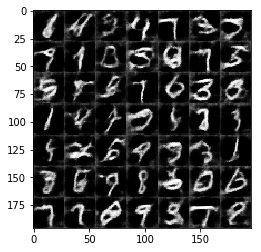

Epoch 1/2... Discriminator Loss: 1.0473... Generator Loss: 1.5532
Epoch 1/2... Discriminator Loss: 0.9919... Generator Loss: 0.9325
Epoch 1/2... Discriminator Loss: 1.2185... Generator Loss: 0.6919
Epoch 2/2... Discriminator Loss: 1.0082... Generator Loss: 1.5274
Epoch 2/2... Discriminator Loss: 1.5669... Generator Loss: 0.4501
Epoch 2/2... Discriminator Loss: 1.1185... Generator Loss: 1.5487
Epoch 2/2... Discriminator Loss: 0.9493... Generator Loss: 1.3837
Epoch 2/2... Discriminator Loss: 1.0350... Generator Loss: 0.8736
Epoch 2/2... Discriminator Loss: 1.1988... Generator Loss: 0.6704
Epoch 2/2... Discriminator Loss: 1.1442... Generator Loss: 1.6113


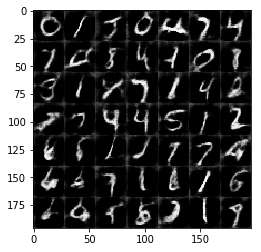

Epoch 2/2... Discriminator Loss: 0.9781... Generator Loss: 2.0893
Epoch 2/2... Discriminator Loss: 1.1293... Generator Loss: 0.7707
Epoch 2/2... Discriminator Loss: 0.9381... Generator Loss: 0.9850
Epoch 2/2... Discriminator Loss: 1.1218... Generator Loss: 0.7278
Epoch 2/2... Discriminator Loss: 0.7663... Generator Loss: 1.2932
Epoch 2/2... Discriminator Loss: 0.9097... Generator Loss: 1.5348
Epoch 2/2... Discriminator Loss: 1.4980... Generator Loss: 2.4003
Epoch 2/2... Discriminator Loss: 1.0917... Generator Loss: 0.7980
Epoch 2/2... Discriminator Loss: 1.2021... Generator Loss: 0.7331
Epoch 2/2... Discriminator Loss: 0.9790... Generator Loss: 1.1002


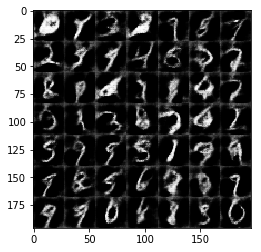

Epoch 2/2... Discriminator Loss: 1.4237... Generator Loss: 0.4631
Epoch 2/2... Discriminator Loss: 1.3302... Generator Loss: 0.6255
Epoch 2/2... Discriminator Loss: 1.3290... Generator Loss: 0.5976
Epoch 2/2... Discriminator Loss: 1.1553... Generator Loss: 1.4949
Epoch 2/2... Discriminator Loss: 1.3938... Generator Loss: 0.5301
Epoch 2/2... Discriminator Loss: 1.0472... Generator Loss: 2.3757
Epoch 2/2... Discriminator Loss: 0.9411... Generator Loss: 0.9685
Epoch 2/2... Discriminator Loss: 0.9916... Generator Loss: 1.6095
Epoch 2/2... Discriminator Loss: 1.4602... Generator Loss: 0.5149
Epoch 2/2... Discriminator Loss: 1.1645... Generator Loss: 1.8371


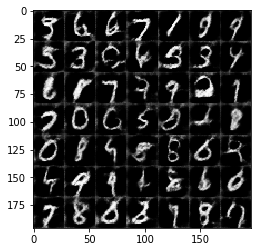

Epoch 2/2... Discriminator Loss: 1.0031... Generator Loss: 1.2764
Epoch 2/2... Discriminator Loss: 0.9909... Generator Loss: 1.3209
Epoch 2/2... Discriminator Loss: 1.1775... Generator Loss: 0.6671
Epoch 2/2... Discriminator Loss: 0.9606... Generator Loss: 0.9684
Epoch 2/2... Discriminator Loss: 1.3181... Generator Loss: 1.5514
Epoch 2/2... Discriminator Loss: 1.0881... Generator Loss: 1.1824
Epoch 2/2... Discriminator Loss: 1.0405... Generator Loss: 1.4551
Epoch 2/2... Discriminator Loss: 1.0269... Generator Loss: 1.0221
Epoch 2/2... Discriminator Loss: 1.1149... Generator Loss: 0.9415
Epoch 2/2... Discriminator Loss: 1.1181... Generator Loss: 1.8334


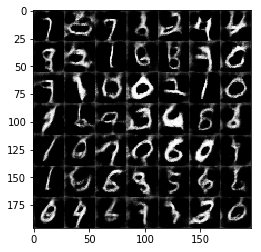

Epoch 2/2... Discriminator Loss: 0.9159... Generator Loss: 1.0599
Epoch 2/2... Discriminator Loss: 0.9340... Generator Loss: 1.3535
Epoch 2/2... Discriminator Loss: 1.6305... Generator Loss: 0.3991
Epoch 2/2... Discriminator Loss: 0.8465... Generator Loss: 1.5322
Epoch 2/2... Discriminator Loss: 1.0975... Generator Loss: 0.8241
Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 0.6375
Epoch 2/2... Discriminator Loss: 1.0452... Generator Loss: 0.9357
Epoch 2/2... Discriminator Loss: 1.0413... Generator Loss: 1.2386
Epoch 2/2... Discriminator Loss: 0.8057... Generator Loss: 1.3234
Epoch 2/2... Discriminator Loss: 0.9577... Generator Loss: 0.9903


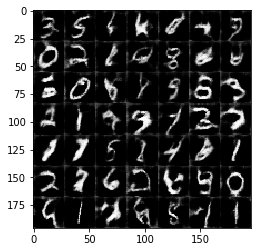

Epoch 2/2... Discriminator Loss: 1.0299... Generator Loss: 1.5405
Epoch 2/2... Discriminator Loss: 1.0255... Generator Loss: 0.8815
Epoch 2/2... Discriminator Loss: 0.9114... Generator Loss: 1.2373
Epoch 2/2... Discriminator Loss: 1.1038... Generator Loss: 0.7838
Epoch 2/2... Discriminator Loss: 1.0955... Generator Loss: 1.8324
Epoch 2/2... Discriminator Loss: 0.9223... Generator Loss: 1.1283
Epoch 2/2... Discriminator Loss: 1.0775... Generator Loss: 0.8292
Epoch 2/2... Discriminator Loss: 1.2398... Generator Loss: 2.2617
Epoch 2/2... Discriminator Loss: 1.2558... Generator Loss: 0.7091
Epoch 2/2... Discriminator Loss: 1.1920... Generator Loss: 0.7104


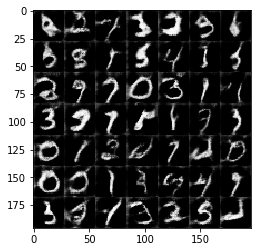

Epoch 2/2... Discriminator Loss: 1.2601... Generator Loss: 0.6467
Epoch 2/2... Discriminator Loss: 0.9874... Generator Loss: 0.9670
Epoch 2/2... Discriminator Loss: 0.8973... Generator Loss: 1.0735
Epoch 2/2... Discriminator Loss: 1.3407... Generator Loss: 0.5862
Epoch 2/2... Discriminator Loss: 1.0245... Generator Loss: 0.9695
Epoch 2/2... Discriminator Loss: 1.0016... Generator Loss: 0.9062
Epoch 2/2... Discriminator Loss: 1.3808... Generator Loss: 0.5860
Epoch 2/2... Discriminator Loss: 0.8883... Generator Loss: 1.2213
Epoch 2/2... Discriminator Loss: 1.4682... Generator Loss: 1.9550
Epoch 2/2... Discriminator Loss: 0.9910... Generator Loss: 1.0309


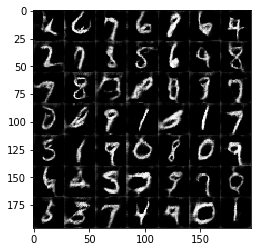

Epoch 2/2... Discriminator Loss: 1.4040... Generator Loss: 0.5684
Epoch 2/2... Discriminator Loss: 1.1694... Generator Loss: 0.7540
Epoch 2/2... Discriminator Loss: 1.0375... Generator Loss: 0.8540
Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 0.7270
Epoch 2/2... Discriminator Loss: 1.1926... Generator Loss: 0.7341
Epoch 2/2... Discriminator Loss: 1.4876... Generator Loss: 3.5559
Epoch 2/2... Discriminator Loss: 1.2340... Generator Loss: 0.7087
Epoch 2/2... Discriminator Loss: 0.6974... Generator Loss: 2.0057
Epoch 2/2... Discriminator Loss: 1.1024... Generator Loss: 1.0005
Epoch 2/2... Discriminator Loss: 0.8991... Generator Loss: 1.0444


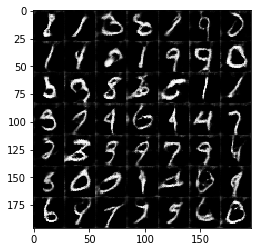

Epoch 2/2... Discriminator Loss: 1.1403... Generator Loss: 0.8152
Epoch 2/2... Discriminator Loss: 1.0501... Generator Loss: 0.9290
Epoch 2/2... Discriminator Loss: 0.9559... Generator Loss: 1.0484
Epoch 2/2... Discriminator Loss: 2.6551... Generator Loss: 5.6776
Epoch 2/2... Discriminator Loss: 1.1685... Generator Loss: 1.4230
Epoch 2/2... Discriminator Loss: 1.0020... Generator Loss: 1.3800
Epoch 2/2... Discriminator Loss: 1.1137... Generator Loss: 0.7954
Epoch 2/2... Discriminator Loss: 0.8875... Generator Loss: 1.1699
Epoch 2/2... Discriminator Loss: 1.4132... Generator Loss: 0.5295
Epoch 2/2... Discriminator Loss: 1.3065... Generator Loss: 0.6497


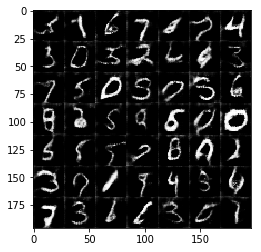

Epoch 2/2... Discriminator Loss: 0.8846... Generator Loss: 1.4290
Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.6147
Epoch 2/2... Discriminator Loss: 1.4687... Generator Loss: 0.5102
Epoch 2/2... Discriminator Loss: 1.1365... Generator Loss: 0.7592
Epoch 2/2... Discriminator Loss: 0.9396... Generator Loss: 1.0453
Epoch 2/2... Discriminator Loss: 1.3051... Generator Loss: 0.6828
Epoch 2/2... Discriminator Loss: 0.8983... Generator Loss: 1.4511


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 3.9627... Generator Loss: 0.0698
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 3.4377
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 0.7206... Generator Loss: 1.6213
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 5.1008
Epoch 1/1... Discriminator Loss: 1.9033... Generator Loss: 0.3462
Epoch 1/1... Discriminator Loss: 0.6377... Generator Loss: 2.1398
Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 2.3803


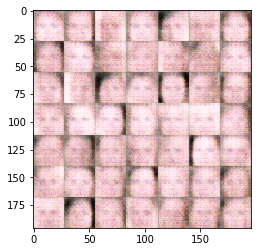

Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 1.9404
Epoch 1/1... Discriminator Loss: 1.6925... Generator Loss: 9.9525
Epoch 1/1... Discriminator Loss: 2.6276... Generator Loss: 6.5948
Epoch 1/1... Discriminator Loss: 2.0527... Generator Loss: 0.4334
Epoch 1/1... Discriminator Loss: 1.7710... Generator Loss: 7.4115
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 2.5883... Generator Loss: 0.1324
Epoch 1/1... Discriminator Loss: 0.7244... Generator Loss: 1.5307
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 1.0015


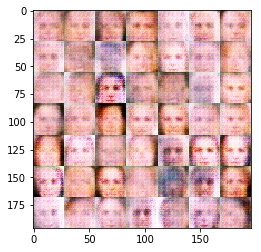

Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 1.7499
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 5.9151
Epoch 1/1... Discriminator Loss: 1.9304... Generator Loss: 0.2839
Epoch 1/1... Discriminator Loss: 1.7559... Generator Loss: 0.4036
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 1.3436
Epoch 1/1... Discriminator Loss: 0.6703... Generator Loss: 1.6989
Epoch 1/1... Discriminator Loss: 2.4280... Generator Loss: 0.2057
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 1.0246


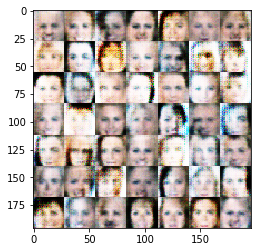

Epoch 1/1... Discriminator Loss: 2.5551... Generator Loss: 0.1533
Epoch 1/1... Discriminator Loss: 0.7904... Generator Loss: 3.8979
Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 3.2266
Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 0.6360... Generator Loss: 2.9995
Epoch 1/1... Discriminator Loss: 2.2229... Generator Loss: 3.6237
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 1.2033
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 1.4460
Epoch 1/1... Discriminator Loss: 0.5474... Generator Loss: 4.2924


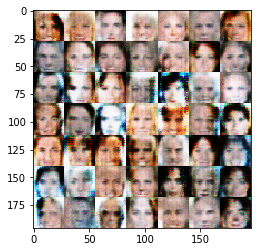

Epoch 1/1... Discriminator Loss: 1.6947... Generator Loss: 0.3310
Epoch 1/1... Discriminator Loss: 0.6394... Generator Loss: 1.9492
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 0.7369... Generator Loss: 1.8466
Epoch 1/1... Discriminator Loss: 2.3275... Generator Loss: 2.3136
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 1.7832
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 3.9476
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 2.1281


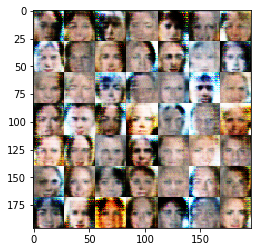

Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 2.4023
Epoch 1/1... Discriminator Loss: 0.7514... Generator Loss: 2.0175
Epoch 1/1... Discriminator Loss: 1.7292... Generator Loss: 0.5054
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.6578... Generator Loss: 4.4168
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 1.9157
Epoch 1/1... Discriminator Loss: 0.4844... Generator Loss: 2.1525
Epoch 1/1... Discriminator Loss: 1.6923... Generator Loss: 0.5193
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 2.0984
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.5535


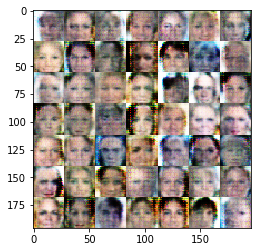

Epoch 1/1... Discriminator Loss: 1.5618... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 1.1401
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 1.5102
Epoch 1/1... Discriminator Loss: 1.8552... Generator Loss: 0.2866
Epoch 1/1... Discriminator Loss: 0.5808... Generator Loss: 2.4194
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.5235
Epoch 1/1... Discriminator Loss: 0.6211... Generator Loss: 2.4498
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 1.2323


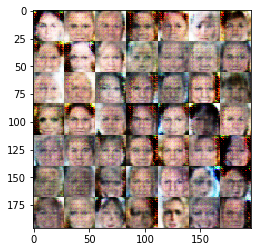

Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.4577
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.5033
Epoch 1/1... Discriminator Loss: 0.6894... Generator Loss: 1.7917
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 1.0477
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.5000
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.8050... Generator Loss: 0.3030


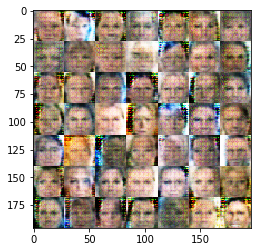

Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.5992... Generator Loss: 3.6568
Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 1.5069
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 1.1751
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 0.6573... Generator Loss: 2.1642
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 2.1149


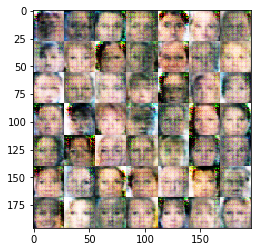

Epoch 1/1... Discriminator Loss: 0.6805... Generator Loss: 1.4911
Epoch 1/1... Discriminator Loss: 2.3088... Generator Loss: 0.1768
Epoch 1/1... Discriminator Loss: 1.8288... Generator Loss: 4.9861
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 2.5790
Epoch 1/1... Discriminator Loss: 2.0030... Generator Loss: 2.2593
Epoch 1/1... Discriminator Loss: 0.8889... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 0.5824... Generator Loss: 2.8237
Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 2.4942
Epoch 1/1... Discriminator Loss: 0.6581... Generator Loss: 2.2954
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.8243


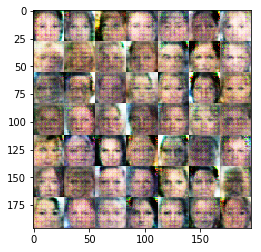

Epoch 1/1... Discriminator Loss: 1.6490... Generator Loss: 2.7906
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.6227... Generator Loss: 0.3701
Epoch 1/1... Discriminator Loss: 0.6400... Generator Loss: 1.6149
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 0.5033... Generator Loss: 3.4755
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 1.6976
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.6410


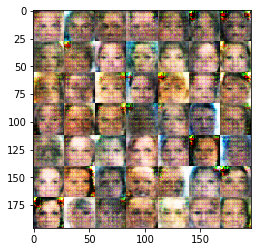

Epoch 1/1... Discriminator Loss: 0.8088... Generator Loss: 2.0054
Epoch 1/1... Discriminator Loss: 0.8513... Generator Loss: 1.4664
Epoch 1/1... Discriminator Loss: 1.7374... Generator Loss: 0.3226
Epoch 1/1... Discriminator Loss: 0.9686... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.7696... Generator Loss: 2.2942
Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 1.2768
Epoch 1/1... Discriminator Loss: 0.8589... Generator Loss: 1.0060
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 1.0332


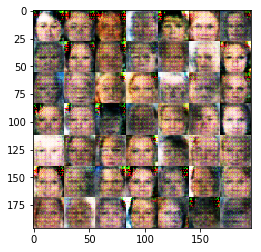

Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 2.0186
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.1601
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.9898
Epoch 1/1... Discriminator Loss: 1.5702... Generator Loss: 3.0547
Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 1.3663
Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 1.8791
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 3.9347
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 2.3553
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 1.1619
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 1.9400


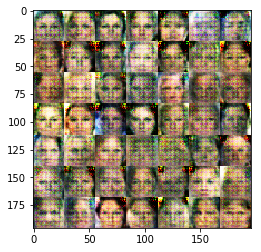

Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 1.5384
Epoch 1/1... Discriminator Loss: 0.8213... Generator Loss: 1.9678
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 1.7891
Epoch 1/1... Discriminator Loss: 1.7735... Generator Loss: 3.2371
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.1423
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 0.5589... Generator Loss: 2.8588
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 2.7712
Epoch 1/1... Discriminator Loss: 0.7282... Generator Loss: 2.7095
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.8428


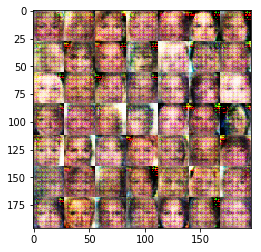

Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 3.9247
Epoch 1/1... Discriminator Loss: 1.6091... Generator Loss: 0.3783
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 2.5308
Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 1.5667
Epoch 1/1... Discriminator Loss: 0.7149... Generator Loss: 2.4286
Epoch 1/1... Discriminator Loss: 0.8019... Generator Loss: 1.3744
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.7925


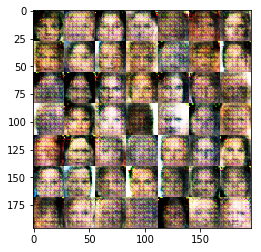

Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 2.3238
Epoch 1/1... Discriminator Loss: 2.5086... Generator Loss: 0.1597
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 0.5087... Generator Loss: 3.7249
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.2549
Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.4027


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.